# Supervised Maching Learning: Eagle Ford Shale 
Forecasting oil production across various shale oil reservoirs poses a complex challenge with significant implications for field appraisal and production planning within the Petroleum Engineering sector. Various reservoir features serve as indicators for production rate profiles, encompassing oil rate, gas rate, and average reservoir pressure.  This notebook shows the performance evaluation of a Neural Network (NN) model a non-linear, high-dimensional petroluem production dataset.  

### 1. Data Cleaning and Feature Engineering
The first step was to acquire the data, which was a numerical simulation-based dataset developed for the Eagle Ford Shale formation. This is a rock formation that lays along the South Texas region. Each of the observations in the dataset was composed of 18 inputs and had output values for the Gas Rate (G), Oil Rate (O), and the Average Reservoir Pressure (A). 

Because they had different production periods, the dataset observations had outputs of different dimensions.  In other words, some samples had Gas Rate, Oil Rate, and Average Reservoir Pressure output data for 2 months, while others had output data for 3 months, 4 months, and so on (see the two figures below). The highest value for the number of months in our data set was 11 months.


#### Visualization of an observation from the dataset with output data for 4 months. Notice that each of the 3 targets has dimension 4:
<img src="Observation4Months.png" alt="4MonthsObservation" />

#### Visualization of an observation from the dataset with output data for 7 months:
<img src="Observation7Months.png" alt="7MonthsObservation" />

The next step required pre-processing of the data. During this step, the data was cleaned and organized so that the models are able to learn from valid dataset observations without any null or undefined values.  

Since the shape of the dataset observations must be the same and because a strong correlation between the output data of the current and previous months was noticed, the data was rearranged in the following manner (see the figure below).

First, each dataset observation was expanded into N samples, where N is the number of months for which the output data is available (i.e. the dimension of the outputs). So, if the dataset observation originally had output dimensions of 3, this dataset observation was expanded to 3 samples. The first of the three new samples had the output data for the 1st month. The second new sample had the output data for the 2nd month and the third new sample had the output data for the 3rd month. This ensured that each output of the samples had the same dimension of 1. Finally, the output data from the previous month was included as part of the inputs.

For example, the third of these 3 new samples contained the output information from the second month as part of its inputs. The second of these new samples contained the output information from the first month as part of its inputs. The first of these new samples contained zeros. This was done because there was no output data for the previous month.

#### Visualization of how an observation from the dataset was prepared for training the models:
<img src="ObservationTransformation.png" alt="ObservationTransformation" />

### 2. Data Preparation
Splitting the data.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel('DATA/cleaned_dataframe.xlsx').iloc[:,1:]

# 596 observations in Dataset, each with id value 1-596
# Split: 80% training, 10% validation, 10% testing
ids = [x for x in range(1,597)]
id_train, id_test_AND_validation, _, __ = train_test_split(ids, ids, test_size=0.2, random_state=42)
id_validation, id_test, _, __ = train_test_split(id_test_AND_validation, id_test_AND_validation, test_size=0.5, random_state=42)
df["Case_Number"] = pd.Series([x for x in df["ID"]]).apply(lambda x : x.split("_")[0])


# Train df, Validation df, Test df
id_train_str = [str(x) for x in id_train]
id_test_str = [str(x) for x in id_test]
id_validation_str = [str(x) for x in id_validation]
train_df = df[df["Case_Number"].apply(lambda x : x in id_train_str)].iloc[:,:-1]
validation_df = df[df["Case_Number"].apply(lambda x : x in id_validation_str)].iloc[:,:-1]
test_df = df[df["Case_Number"].apply(lambda x : x in id_test_str)].iloc[:,:-1]


### 3. Train Machine Learning Model

#### Neural Network

In [3]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000, restore_best_weights=True)
from tensorflow.keras.layers import Dropout
import joblib
import random
import matplotlib.pyplot as plt



In [4]:
# Scaler
scaler = MinMaxScaler()
scaler.fit(train_df.iloc[:,1:-3].values)
joblib.dump(scaler,'scaler.pkl')

['scaler.pkl']

In [5]:
# Scaling Data
X_train = scaler.transform(train_df.iloc[:,1:-3].values)
X_validation = scaler.transform(validation_df.iloc[:,1:-3].values)
X_test = scaler.transform(test_df.iloc[:,1:-3].values)

In [6]:
# Outpus
y_train = train_df.iloc[:,-3:].values
y_validation = validation_df.iloc[:,-3:].values
y_test = test_df.iloc[:,-3:].values


In [ ]:
# Loop to find best model
model_error = float('inf')
best_model = ''
for n1 in range(600, 700, 5):
     
    for n2 in range(800,900, 5):
        print(f"{n1} _ {n2}: ")
     
        # Creating Neural Network
        model = Sequential()
        model.add(Dense(n1, input_dim=18, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(n2, input_dim=18, activation='relu'))
        model.add(Dropout(0.2))
        model_name = "two_layer_" + str(n1) + "_neurons_" + str(n2) + "_neurons"
        print(model_name)

        model.add(Dense(3))
        model.compile(optimizer='adam', loss='mse')

        model.fit(x=X_train, y=y_train,batch_size=128, epochs=5000, validation_data=(X_validation, y_validation),
                  verbose=0,callbacks=[early_stop])
        
        X_test_predictions = model.predict(scaler.transform(test_df.iloc[:,1:-3].values))
        current_error = mean_absolute_percentage_error(y_test, X_test_predictions)*100 
      
        if current_error < 15:
            if (current_error < model_error):
                model_error = current_error
                best_model = model_name
                print("ERROR UPDATE")
                print(f'Best Model: {best_model}')
                model.save("best-models\\" + best_model + "_error_" + str(int(model_error))  + ".h5")

        print(f"Current Model Error: {current_error}")

print(f"Best Model: {best_model}")       
print(f"Best Model Error: {model_error}")


### 4. Testing Machine Learning Model

Using the code in the previous cell, I was able to find a neural network with an error of 6.25 percent and saved it.
Next, I will load the neural network model and calculate its error again. 

In [8]:
from tensorflow.keras.models import load_model

In [9]:
model = load_model('best-models/two_layer_620_neurons_875_neurons_error_6.h5')
X_test_predictions = model.predict(scaler.transform(test_df.iloc[:,1:-3].values))

In [10]:
print('Model Error: ', mean_absolute_percentage_error(y_test, X_test_predictions)*100 )

Model Error:  6.257693049805269


### 5. Predicting a random dataset observation 

In [11]:
# Creating a dataframe with predicitons included
nn_prediction_df = test_df.copy()
nn_prediction_df['Gas_Rate_Pred'] = list(map(lambda x: x[0], X_test_predictions))
nn_prediction_df['Oil_Rate_Pred'] = list(map(lambda x: x[1], X_test_predictions))
nn_prediction_df['Ave_Pres_Pred'] = list(map(lambda x: x[2], X_test_predictions))

In [12]:
# Adding errors to each observation
nn_prediction_df['Case_Number'] = list(pd.Series([x for x in nn_prediction_df["ID"]]).apply(lambda x : x.split("_")[0]))

In [13]:
# Select 1 random cases
number_of_months = 0
while(number_of_months<5):
    selected_case = random.choice(nn_prediction_df['Case_Number'].unique())
    case_1 = nn_prediction_df[nn_prediction_df['Case_Number']==selected_case]
    selected_case_targets = case_1[['Gas_Rate_N','Oil_Rate_N' , 'Ave_Pres_N' ]]
    selected_case_preds = case_1[['Gas_Rate_Pred','Oil_Rate_Pred' , 'Ave_Pres_Pred']]
    number_of_months = len(selected_case_targets)


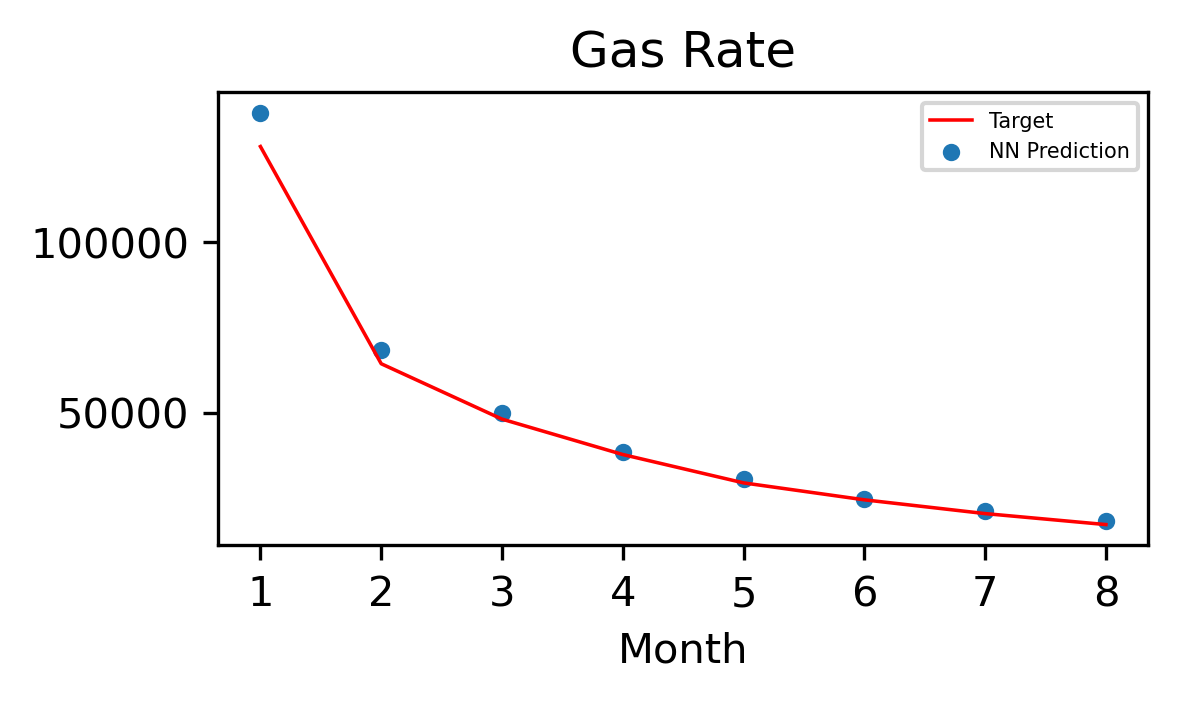

In [14]:
# Gas Rate Target Vs Prediction
x_ax = range(1, len(selected_case_targets)+1)
plt.figure(figsize=(4,2), dpi=300)
plt.title("Gas Rate")
plt.plot(x_ax,selected_case_targets["Gas_Rate_N"], 'r', linewidth=.85)
plt.scatter(x_ax,selected_case_preds["Gas_Rate_Pred"], s=10 )
plt.xticks(ticks=x_ax)
plt.xlabel("Month")
plt.legend(["Target", "NN Prediction"],prop={'size': 5})
plt.show()

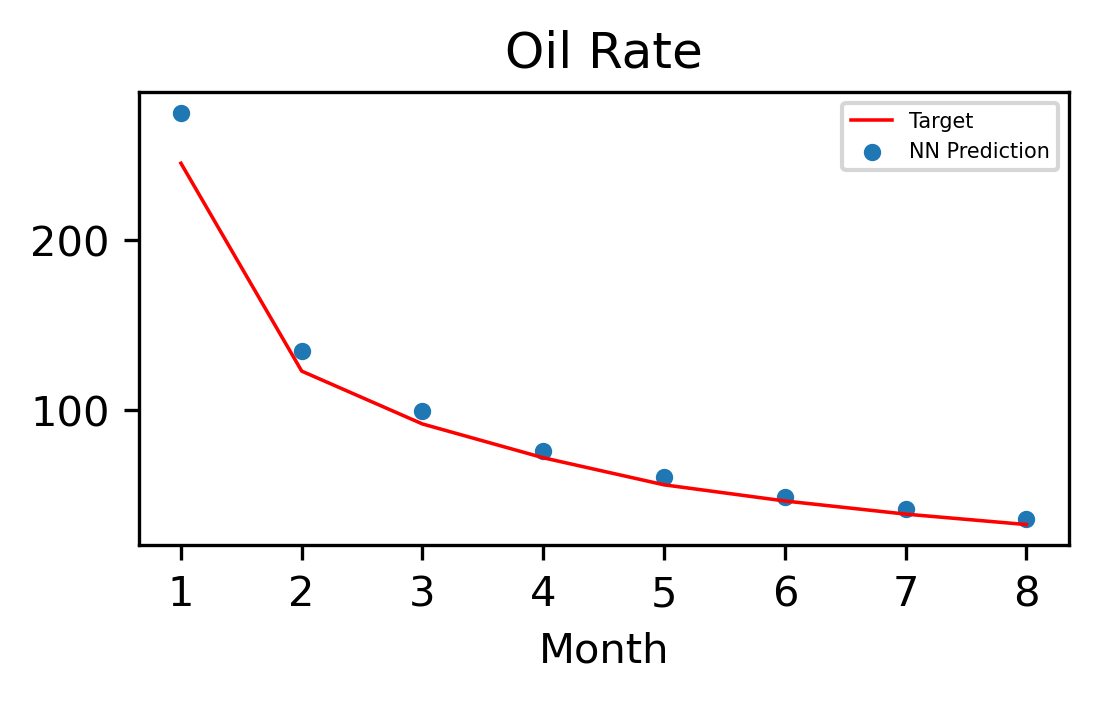

In [15]:
# Oil Rate Target Vs Prediction
x_ax = range(1, len(selected_case_targets)+1)
plt.figure(figsize=(4,2), dpi=300)
plt.title("Oil Rate")
plt.plot(x_ax,selected_case_targets["Oil_Rate_N"], 'r', linewidth=.85)
plt.scatter(x_ax,selected_case_preds["Oil_Rate_Pred"], s=10 )
plt.xticks(ticks=x_ax)
plt.xlabel("Month")
plt.legend(["Target", "NN Prediction"], prop={'size': 5})
plt.show()

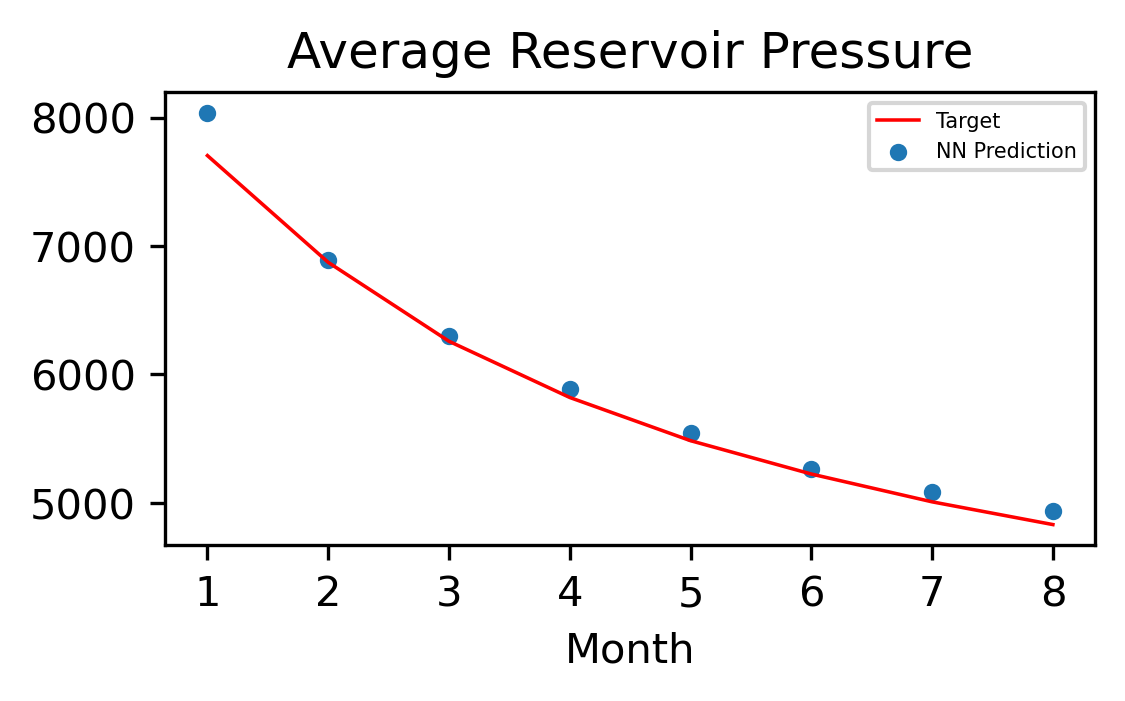

In [16]:
# Average Reservoir Pressure Target Vs Prediction
x_ax = range(1, len(selected_case_targets)+1)
plt.figure(figsize=(4,2), dpi=300)
plt.title("Average Reservoir Pressure")
plt.plot(x_ax,selected_case_targets["Ave_Pres_N"], 'r', linewidth=.85)
plt.scatter(x_ax,selected_case_preds["Ave_Pres_Pred"], s=10 )
plt.xticks(ticks=x_ax)
plt.xlabel("Month")
plt.legend(["Target", "NN Prediction"], prop={'size': 5})
plt.show()

### 6. Updated Model Prediction

In order to create more realistic predictions, the model is tasked to predict on a month by month basis in the following manner. The model first makes a prediction for Month 1. Then, the models uses the prediction of Month 1 to make a prediction for Month 2. The prediction for Month 2 is then used to predict Month 3, and so on (see the figure below).  This is done because the previous month data used as part of the inputs is not known and must be predicted.
#### Model prediction pocess for a dataset observation with output data for 3 months. The model makes predictions month by month because in the real world the data for future months is unknown.  The data from the previous month must be obtained (predicted) before it is used. 

<img src="PredictionProcess.png" alt="PredictionProcess" />

In [17]:
# Using model to predict on month to month basis 
# previous month prediction will be used to predict next month
zeros_indeces = []
for i in range(597):
    zeros_indeces.append(str(i)+"_1")
test_df_predictions = test_df.copy()  

for i in range(len(test_df_predictions)):
    index = test_df_predictions.index[i]
    if test_df_predictions.iloc[i]["ID"] in zeros_indeces:

        current_prediction = model.predict(scaler.transform(test_df_predictions.iloc[i,1:-3].values.reshape(1,-1)))

        test_df_predictions.loc[index, "Gas_Rate_N"] = current_prediction[0][0]
        test_df_predictions.loc[index, "Oil_Rate_N"] = current_prediction[0][1]
        test_df_predictions.loc[index, "Ave_Pres_N"] = current_prediction[0][2]

    else:

        test_df_predictions.loc[index, "Gas_Rate_N-1"] = test_df_predictions.loc[index-1, "Gas_Rate_N"]
        test_df_predictions.loc[index, "Oil_Rate_N-1"] = test_df_predictions.loc[index-1, "Oil_Rate_N"]
        test_df_predictions.loc[index, "Ave_Pres_N-1"] = test_df_predictions.loc[index-1, "Ave_Pres_N"]

        current_prediction = model.predict(scaler.transform(test_df_predictions.iloc[i,1:-3].values.reshape(1,-1)))

        test_df_predictions.loc[index, "Gas_Rate_N"] = current_prediction[0][0]
        test_df_predictions.loc[index, "Oil_Rate_N"] = current_prediction[0][1]
        test_df_predictions.loc[index, "Ave_Pres_N"] = current_prediction[0][2]


 

In [18]:
# Model error with more realistic predictions 
X_test_predictions = model.predict(scaler.transform(test_df_predictions.iloc[:,1:-3].values))
current_error = mean_absolute_percentage_error(y_test, X_test_predictions)*100 
print(current_error)

15.606539304671571


As expected, making more realistic predictions leads to a higher error.  

In [19]:
test_df_predictions['Case_Number'] = list(pd.Series([x for x in test_df_predictions["ID"]]).apply(lambda x : x.split("_")[0]))
case_2 = test_df_predictions[test_df_predictions['Case_Number']==selected_case]
selected_case_preds_2 = case_2[['Gas_Rate_N','Oil_Rate_N' , 'Ave_Pres_N']]

### 7. Graphing Updated Model Prediction 

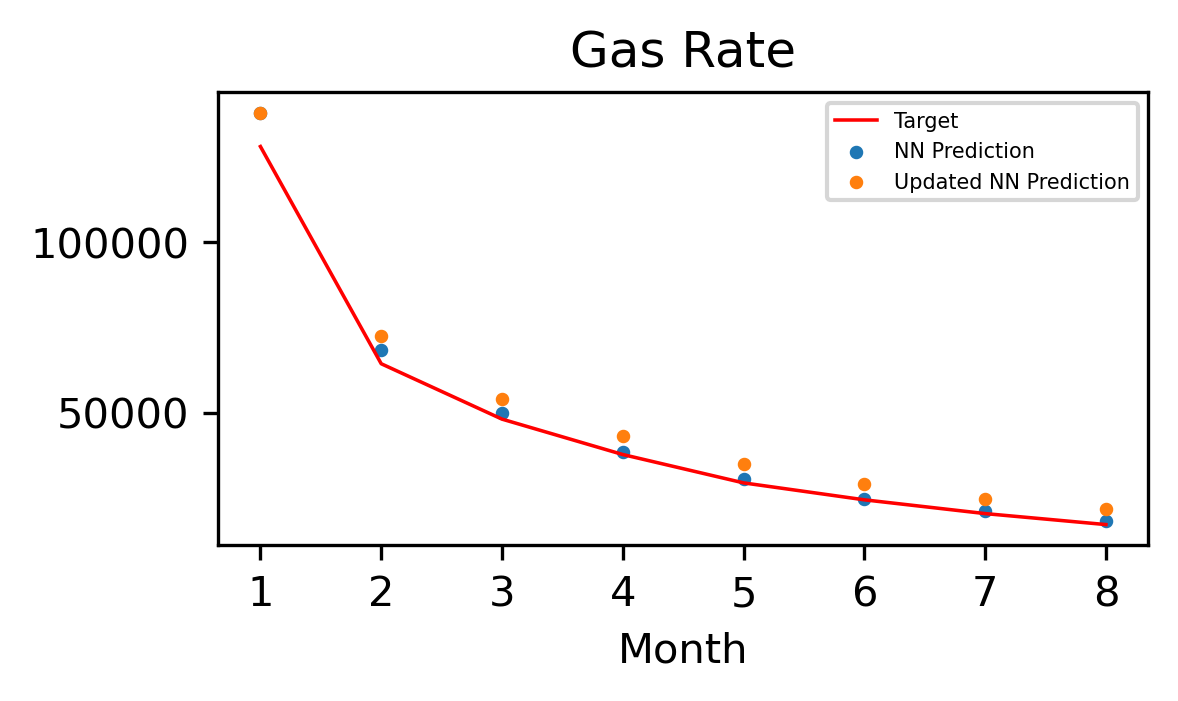

In [20]:
# Gas Rate Target Vs Prediction
x_ax = range(1, len(selected_case_targets)+1)
plt.figure(figsize=(4,2), dpi=300)
plt.title("Gas Rate")
plt.plot(x_ax,selected_case_targets["Gas_Rate_N"], 'r', linewidth=.85)
plt.scatter(x_ax,selected_case_preds["Gas_Rate_Pred"], s=5 )
plt.scatter(x_ax,selected_case_preds_2["Gas_Rate_N"], s=5 )
plt.xticks(ticks=x_ax)
plt.xlabel("Month")
plt.legend(["Target", "NN Prediction", "Updated NN Prediction"],prop={'size': 5})
plt.show()

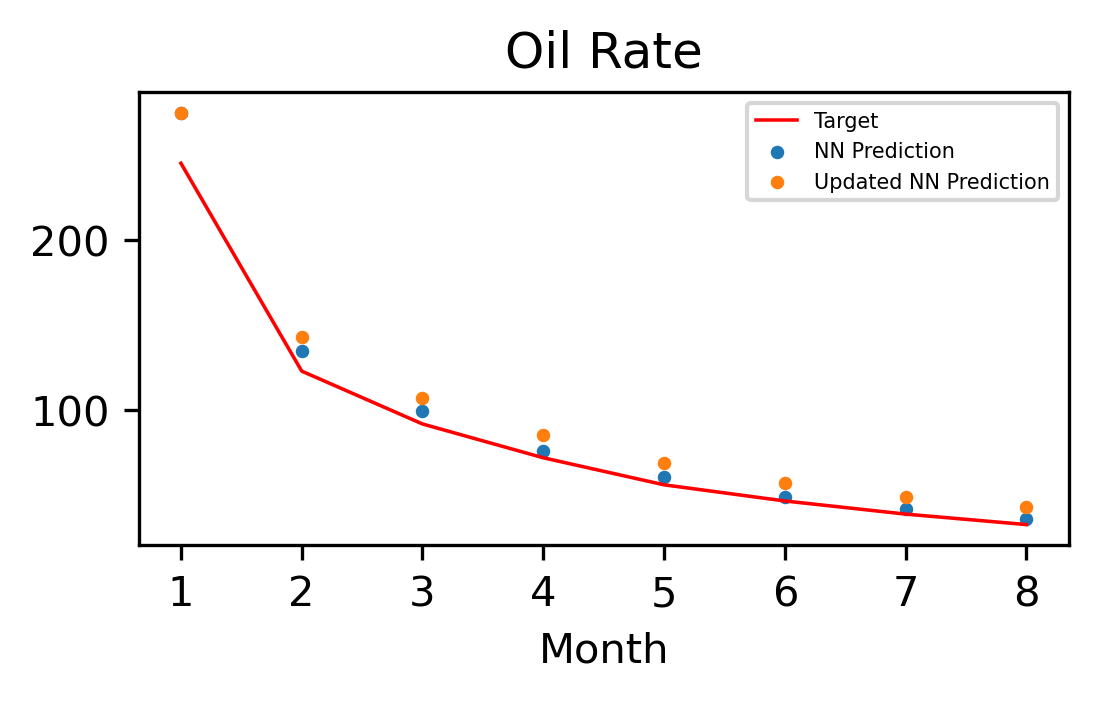

In [21]:
# Oil Rate Target Vs Prediction
x_ax = range(1, len(selected_case_targets)+1)
plt.figure(figsize=(4,2), dpi=300)
plt.title("Oil Rate")
plt.plot(x_ax,selected_case_targets["Oil_Rate_N"], 'r', linewidth=.85)
plt.scatter(x_ax,selected_case_preds["Oil_Rate_Pred"], s=5 )
plt.scatter(x_ax,selected_case_preds_2["Oil_Rate_N"], s=5 )
plt.xticks(ticks=x_ax)
plt.xlabel("Month")
plt.legend(["Target", "NN Prediction", "Updated NN Prediction"], prop={'size': 5})
plt.show()

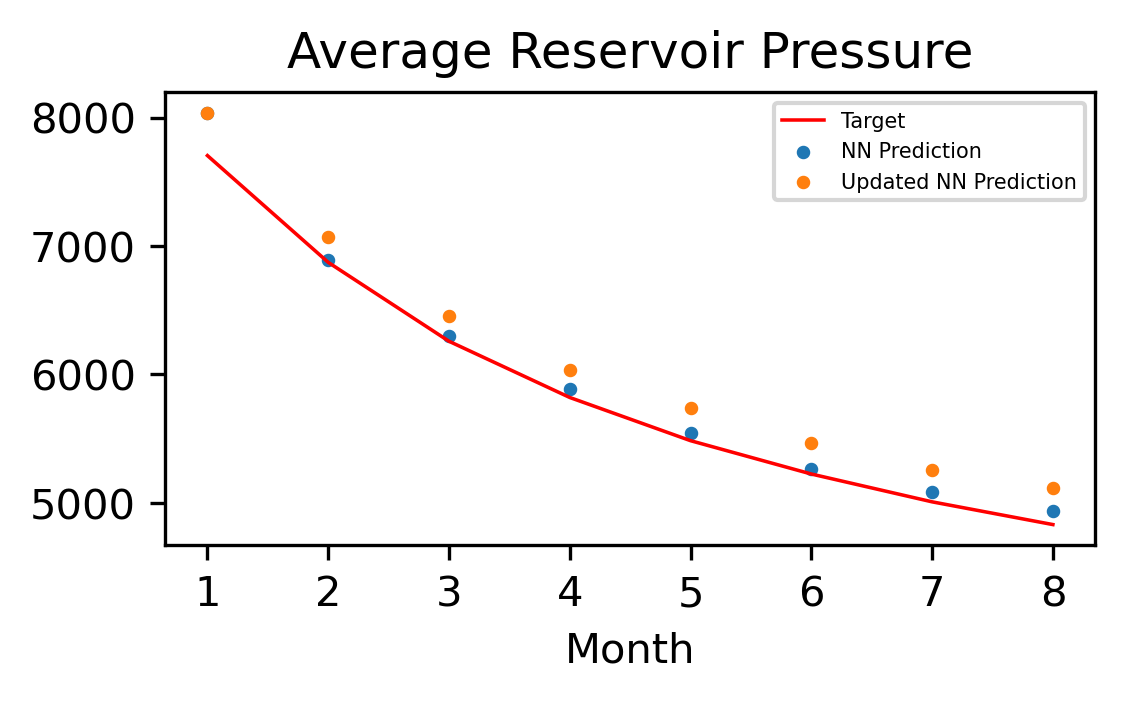

In [22]:
# Average Reservoir Pressure Target Vs Prediction
x_ax = range(1, len(selected_case_targets)+1)
plt.figure(figsize=(4,2), dpi=300)
plt.title("Average Reservoir Pressure")
plt.plot(x_ax,selected_case_targets["Ave_Pres_N"], 'r', linewidth=.85)
plt.scatter(x_ax,selected_case_preds["Ave_Pres_Pred"], s=5 )
plt.scatter(x_ax,selected_case_preds_2["Ave_Pres_N"], s=5 )
plt.xticks(ticks=x_ax)
plt.xlabel("Month")
plt.legend(["Target", "NN Prediction", "Updated NN Prediction"], prop={'size': 5})
plt.show()